## This model works on the __Multiplier Ratio (_r_)__ prediction for the __Logan VT Rescaling__.

### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from resources import *

/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Read The Data

Notice: If the data we use have been changed, refer to `New Regression.ipynb`

In [3]:
path_noaif = "../LoganVT_noAIF.xlsx"

In [4]:
path_retest = "/Users/darenma/Downloads/AIF_PBIF_ML_Updated_NormBy_AUCPredictedFromWeightAndDose_MRTM2/ATLAS_MS_ReTest_Regional_Analysis_AIF_vs_PBIF.xlsx"
path_test = "/Users/darenma/Downloads/AIF_PBIF_ML_Updated_NormBy_AUCPredictedFromWeightAndDose_MRTM2/ATLAS_MS_Test_Regional_Analysis_AIF_vs_PBIF.xlsx"
path_PD = "/Users/darenma/Downloads/AIF_PBIF_ML_Updated_NormBy_AUCPredictedFromWeightAndDose_MRTM2/ATLAS_PD_Regional_Analysis_AIF_vs_PBIF.xlsx"

In [5]:
# TODO:
# get the slope for these data <- get the demographics
# calculate the acctual data they should be on.
Logan_noaif = pd.read_excel(path_noaif, sheet_name="LoganVT-PBIF").drop(columns=['Region #'])
Xnoaif = pd.read_csv("../Demographic_noaif.csv")

In [6]:
Rnoaif = Logan_noaif.describe().T[['mean', 'std']].reset_index().copy()
Rnoaif.columns = ['ID2', 'mean', 'std']
Xn = pd.concat([Xnoaif, Rnoaif], axis=1)

Logan_noaif.index = Logan_noaif.Regions
Z = Logan_noaif.T.iloc[1:]

In [7]:
df_plot_new_predictions = pd.read_csv("ml_results_long.csv")

In [8]:
Z = Z.reset_index()
Zm = pd.melt(Z, id_vars=['index'], value_vars=Z.columns[1:], value_name="VT_PBIF")
Zm.columns = ['ID', "Regions", "VT_PBIF"]

In [9]:
Zm

,ID,Regions,VT_PBIF
0,1010,ctx-lh-bankssts,4.390685
1,1016,ctx-lh-bankssts,3.834836
2,1017,ctx-lh-bankssts,3.562948
3,1027,ctx-lh-bankssts,3.297651
4,1028,ctx-lh-bankssts,8.380674
...,...,...,...
1113,1041,Right-VentralDC,5.974306
1114,1047,Right-VentralDC,9.167541
1115,1049,Right-VentralDC,8.742227
1116,1051,Right-VentralDC,3.912358


## Don't Run if Not Re-modeling!

In [11]:
#sheet_name
xsh = "LoganVT-PBIF"
ysh = "LoganVT-AIF"
rsh = "MRTM2-BPnd"
X_PD = pd.read_excel(path_PD, sheet_name=xsh)
X_test = pd.read_excel(path_test, sheet_name=xsh)
X_retest = pd.read_excel(path_retest, sheet_name=xsh)

Y_PD = pd.read_excel(path_PD, sheet_name=ysh)
Y_test = pd.read_excel(path_test, sheet_name=ysh)
Y_retest = pd.read_excel(path_retest, sheet_name=ysh)

R_PD = pd.read_excel(path_PD, sheet_name=rsh)
R_test = pd.read_excel(path_test, sheet_name=rsh)
R_retest = pd.read_excel(path_retest, sheet_name=rsh)

In [12]:
X_test.columns= ['Regions', 'Region #', 'FR', 'JD', 'KT', 'MM', 'PP']
Y_test.columns= ['Regions', 'Region #', 'FR', 'JD', 'KT', 'MM', 'PP']
R_test.columns= ['Regions', 'Region #', 'FR', 'JD', 'KT', 'MM', 'PP']

R_retest.columns= ['Regions', 'Region #', 'r-FR', 'r-JD', 'r-KT', 'r-MM', 'r-PP']

X_retest.columns= ['Regions', 'Region #', 'r-FR', 'r-JD', 'r-KT', 'r-MM', 'r-PP']
Y_retest.columns= ['Regions', 'Region #', 'r-FR', 'r-JD', 'r-KT', 'r-MM', 'r-PP']

In [13]:
aif_new

,ATLaS_ID,Age,Sex,NET dose (mCi),"Height (Feet, inches)",Weight (Kgs),Genotype
0,1001,68,1,16.09,5'7'',81.646627,2
1,1002,59,1,14.36,5'10'',81.646627,2
2,1003,63,1,12.86,6',81.646627,1
3,1004,71,1,13.37,5'9'',65.770894,2
4,1005,62,1,13.50,5'10'',56.245454,2
5,1007,62,1,14.86,6',131.541787,2
6,1009,55,0,11.15,5'3'',55.338269,1
7,1013,68,1,15.49,5'10'',77.110703,1
8,1015,68,1,12.65,5'7'',81.646627,2
9,1020,65,0,16.59,5'10'',69.853225,2


In [14]:
X = pd.concat([X_PD.drop(columns=["Region #"]), X_test.drop(columns=["Regions", "Region #"]), X_retest.drop(columns=["Regions", "Region #"])], axis=1)
Y = pd.concat([Y_PD.drop(columns=["Region #"]), Y_test.drop(columns=["Regions", "Region #"]), Y_retest.drop(columns=["Regions", "Region #"])], axis=1)


X = X.T.reset_index()
X.columns = X.iloc[0]
X = X.iloc[1:].rename(columns={"Regions":"ATLaS_ID"}).reset_index().drop(columns='index')


Y = Y.T.reset_index()
Y.columns = Y.iloc[0]
Y = Y.iloc[1:].rename(columns={"Regions":"ATLaS_ID"}).reset_index().drop(columns='index')

X = pd.concat([aif_new, X.drop(columns=["ATLaS_ID"])], axis=1)
Y = pd.concat([aif_new, Y.drop(columns=["ATLaS_ID"])], axis=1)


# Y_train = pd.concat([aif_new, Y_train.drop(columns=["ATLaS_ID"])], axis=1)


In [15]:
R = pd.concat([R_PD.drop(columns=["Region #"]), R_test.drop(columns=[
              "Regions", "Region #"]), R_retest.drop(columns=["Regions", "Region #"])], axis=1)
R = R.T.reset_index()
R.columns = R.iloc[0]
R = R.iloc[1:].rename(columns={"Regions":"ATLaS_ID"}).reset_index().drop(columns='index')
R = pd.concat([aif_new, R.drop(columns=["ATLaS_ID"])], axis=1)

In [16]:
R

,ATLaS_ID,Age,Sex,NET dose (mCi),"Height (Feet, inches)",Weight (Kgs),Genotype,ctx-lh-bankssts,ctx-lh-caudalanteriorcingulate,ctx-lh-caudalmiddlefrontal,...,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC
0,1001,68,1,16.09,5'7'',81.646627,2,0.647637,0.540017,0.202705,...,0.578161,-0.155817,0.738007,0.127752,0.215209,0.879487,0.150667,0.82213,0.382875,0.595055
1,1002,59,1,14.36,5'10'',81.646627,2,0.167196,0.182068,0.142415,...,0.225161,0.174506,0.344627,-0.078082,0.21891,0.218432,0.113977,0.219067,0.233099,0.256026
2,1003,63,1,12.86,6',81.646627,1,-0.024597,0.165421,0.000332,...,0.387461,-0.069193,0.233049,-0.125834,0.00834,0.175888,0.129528,0.21402,0.12878,0.317172
3,1004,71,1,13.37,5'9'',65.770894,2,0.168688,-0.048298,-0.040354,...,0.049467,0.048191,0.254886,-0.32768,0.166357,0.139295,-0.050429,-0.096324,-0.075594,0.052679
4,1005,62,1,13.50,5'10'',56.245454,2,0.093672,0.218948,0.052309,...,0.196759,0.017623,0.26057,-0.012713,0.20992,0.201268,0.052928,0.140779,0.271711,0.136445
5,1007,62,1,14.86,6',131.541787,2,0.226879,0.179036,0.130806,...,0.085902,0.038951,0.331553,-0.060716,0.24899,0.20765,0.052099,0.113125,0.271309,0.137331
6,1009,55,0,11.15,5'3'',55.338269,1,0.134074,0.091906,0.043124,...,0.099364,0.126533,0.280948,-0.05899,0.218566,0.13986,0.084237,0.091322,0.090855,0.120872
7,1013,68,1,15.49,5'10'',77.110703,1,0.09308,-0.009446,0.029091,...,0.225452,0.05316,0.340986,-0.106264,0.209164,0.313622,0.091756,0.247753,0.195769,0.216191
8,1015,68,1,12.65,5'7'',81.646627,2,0.125113,0.00672,0.142558,...,-0.181574,0.069792,0.183385,-0.044301,0.308871,-0.031309,-0.07178,-0.127037,0.06398,-0.166165
9,1020,65,0,16.59,5'10'',69.853225,2,0.174133,0.23389,0.006141,...,-0.007885,0.166892,0.187859,-0.280811,0.119819,-0.073215,-0.024874,-0.062538,0.010951,0.046746


In [17]:
df_long = pd.melt(X, id_vars=['ATLaS_ID', 'Age', 'Sex', 'NET dose (mCi)', 'Height (Feet, inches)',
       'Weight (Kgs)', 'Genotype'], value_vars=X.columns[7:], value_name="VT_PBIF")
df_long_Y = pd.melt(Y, id_vars=['ATLaS_ID', 'Age', 'Sex', 'NET dose (mCi)', 'Height (Feet, inches)',
       'Weight (Kgs)', 'Genotype'], value_vars=Y.columns[7:], value_name="VT_AIF")
df_long_R = pd.melt(R, id_vars=['ATLaS_ID', 'Age', 'Sex', 'NET dose (mCi)', 'Height (Feet, inches)',
       'Weight (Kgs)', 'Genotype'], value_vars=R.columns[7:], value_name="VT_Rebalanced")
df_long.loc[:, "VT_AIF"] = df_long_Y["VT_AIF"]
df_long.loc[:, "VT_Rebalanced"] = df_long_R["VT_Rebalanced"]

In [18]:
# # The Logan VT from PBIF-generated pAIFs. 
# X_1 = pd.read_csv("../AUC-PBIF-X.csv", index_col=0)

# # The Logan VT from Observed AIFs. 
# Y = pd.read_csv("../ground_truth.csv", index_col=0)

# # The dataset to make the scatter and results plots.
# df_plot_long = pd.read_csv("../Table_For_Plots.csv", index_col=0)

In [19]:
df_long= df_long.drop(columns=['Age', 'Sex', 'NET dose (mCi)', 'Height (Feet, inches)',
       'Weight (Kgs)', 'Genotype'])

In [20]:
df_long.rename(columns={"variable":"Region"})

,ATLaS_ID,Region,VT_PBIF,VT_AIF,VT_Rebalanced
0,1001,ctx-lh-bankssts,3.273644,3.251007,0.647637
1,1002,ctx-lh-bankssts,4.641621,4.354113,0.167196
2,1003,ctx-lh-bankssts,4.330583,6.688563,-0.024597
3,1004,ctx-lh-bankssts,5.02903,4.902443,0.168688
4,1005,ctx-lh-bankssts,5.931887,6.328522,0.093672
...,...,...,...,...,...
1887,r-FR,Right-VentralDC,3.347274,3.289047,1.044053
1888,r-JD,Right-VentralDC,5.30888,4.971977,0.412965
1889,r-KT,Right-VentralDC,2.726502,2.56848,-0.463781
1890,r-MM,Right-VentralDC,9.086933,9.188052,-0.450177


### Compute the "slope" r

In [101]:
# X = X_1.iloc[:,6:].values

# print(X.shape)

# Y = Y.values

# print(Y.shape)

# r = np.zeros(34)
# for i in range(34):
#     xi = X[i]
#     yi = Y[i]
#     r[i] = np.dot(xi, yi)/np.dot(xi, xi)  

### New data

In [21]:
X_train = X.iloc[:,7:].values.astype(float)
print(X_train.shape)
Y_train = Y.iloc[:,7:].values.astype(float)
print(Y_train.shape)
r = np.zeros(22)
for i in range(22):
    xi = X_train[i]
    yi = Y_train[i]
    r[i] = np.dot(xi, yi)/np.dot(xi, xi)  

(22, 86)
(22, 86)


The numpy array `r` contains the 34 target values we are trying to predict.

In [22]:
r

array([0.9769603 , 0.94203049, 1.55600253, 0.97655938, 1.06943871,
       1.11387877, 1.19244167, 0.97438815, 0.93362878, 1.11705387,
       0.98144882, 0.93563277, 0.9108282 , 1.01922255, 0.83727475,
       0.95079081, 1.14657403, 0.98071945, 0.93704234, 0.95848533,
       1.01075947, 1.10693682])

### Modeling

In [23]:
X_train.shape

(22, 86)

In [24]:
sns.set(rc={"figure.figsize":(7, 7)})

selected_features = ['Age', 'Sex', 'NET dose (mCi)', 'Weight (Kgs)', 'Genotype', "mean", "std"]
X_ = X.iloc[:,7:].astype(float)
X.loc[:, "mean"] = (X_.T.describe().T)["mean"]
X.loc[:, "std"] = (X_.T.describe().T)["std"]

In [25]:
X[selected_features].iloc[:17]

,Age,Sex,NET dose (mCi),Weight (Kgs),Genotype,mean,std
0,68,1,16.09,81.646627,2,3.016650,0.300098
1,59,1,14.36,81.646627,2,4.636139,0.424387
2,63,1,12.86,81.646627,1,4.516313,0.385808
3,71,1,13.37,65.770894,2,4.524622,0.607412
4,62,1,13.50,56.245454,2,5.645432,0.727373
5,62,1,14.86,131.541787,2,3.602043,0.419285
6,55,0,11.15,55.338269,1,3.097162,0.249616
7,68,1,15.49,77.110703,1,3.602114,0.361411
8,68,1,12.65,81.646627,2,4.579842,0.366714
9,65,0,16.59,69.853225,2,5.527309,0.466258


In [26]:
# Gradient Boosting
selected_features = ['Age', 'NET dose (mCi)', 'Weight (Kgs)', "mean", "std"]
# Xm = X.iloc[:17,:][selected_features].values
# Xn = X.iloc[17:,:][selected_features].values
X_t = X[selected_features].values
model_slope = GradientBoostingRegressor(random_state=22, 
                        min_samples_leaf=2, 
                        n_estimators=400, 
                        max_features=3, 
                        max_leaf_nodes=2,
                        min_samples_split=2,
                        learning_rate=0.06,
                               )

model_slope.fit(X_t, r)  
base_model_accuracy = evaluate(model_slope, X_t, r)
y_hat = model_slope.predict(X_t)
print(r2_score(r, y_hat))
# yhat_slope = model_slope.predict(Xm)
# yhat_retest = model_slope.predict(Xn)
# print(r2_score(r[:17], yhat_slope))
# print(r2_score(r[17:], yhat_retest))

Model Performance
Average Error: 0.0446 degrees.
Accuracy = 95.85%.
0.8235108977050936


In [27]:
selected_features_n = ['Age', 'NETdose(mCi)', 'Weight(Kgs)', "mean", "std"]
Xn_t = Xn[selected_features_n]
yn_hat = model_slope.predict(Xn_t)

In [28]:
Zm

,ID,Regions,VT_PBIF
0,1010,ctx-lh-bankssts,4.390685
1,1016,ctx-lh-bankssts,3.834836
2,1017,ctx-lh-bankssts,3.562948
3,1027,ctx-lh-bankssts,3.297651
4,1028,ctx-lh-bankssts,8.380674
...,...,...,...
1113,1041,Right-VentralDC,5.974306
1114,1047,Right-VentralDC,9.167541
1115,1049,Right-VentralDC,8.742227
1116,1051,Right-VentralDC,3.912358


In [29]:
Xn

,ID,Age,Sex,H&Y stage,NETdose(mCi),NETdose(Mbq),Weight(Lbs),Weight(Kgs),Height,Genotype,ID2,mean,std
0,1010,58,M,2,14.33,530.21,156,70.760410,6',AG,1010,4.778480,0.569142
1,1016,67,M,2,15.88,587.57,180,81.646627,5'9'',AG,1016,3.986379,0.406623
2,1017,59,M,1,14.24,526.80,235,106.594207,6'2'',GG,1017,3.799871,0.408688
3,1027,71,M,2,15.81,584.98,194,87.996920,6',GG,1027,3.475866,0.516563
4,1028,73,F,2,16.60,614.02,122,55.338269,5'1'',GG,1028,7.813456,1.377896
5,1029,70,F,2,15.20,NaN,174,78.925072,5'3'',AA,1029,4.427731,0.971616
6,1031,69,F,1,12.64,467.58,140,63.502932,"5'58""",AG,1031,2.261685,0.211778
7,1032,70,M,2,13.54,500.92,172,78.017888,6',AG,1032,8.576813,0.989346
8,1041,56,F,1,15.77,583.50,116,52.616715,5'4'',GG,1041,5.005933,0.422974
9,1047,62,M,2,12.97,479.66,190,86.182550,6',GG,1047,7.527280,0.867483


All the data we have right now. 25 PD (12 old 13 new) + 5(10) CN.

Show their distributions using Violin Plots, along with the previous IDs.
Fig 1: 3 violins: Logan_AIF; Logan_PBIF; Logan_PBIF_noAIF - Daren. 
Also compare with the GenoType. Age. Sex and so on. - Daren
SUVR comparison - scatter plot. One axis VT, another SUVR. - Daren

Moving to PD related analysis.
Fig 2: GlassBrain on avg VT; GB on avg atropy; corr between VT and atropy; corr between VT and phenotypes - Sneha.
Invovle avg regional values; 

Fig 3 or 4: NDM on SRV

Time Frame: Fig 1 and 2 done in 1-2 weeks. MRTM 2-3 weeks.

Q: Different algorithm for the AD?
A: FreeSurfer MRTM tool on reference region. FS vs PMOD: batching -> runtime is shorter.
Q: fitting VTs, some regions don't fit well? 
A: Ouliet removal for certain regions and/or certain subjs.

Expanded Version of PBIF algorithm.
Previous: predicting AUC. Now: predicting shape of the curve.
Linear ODE on 4 parameters. May not work. 
OR, fit an equation of time using PySR. 

In [31]:
#
yn_hat

array([0.97404043, 1.00217016, 0.99614051, 0.92544743, 0.96153056,
       0.94398695, 1.0138252 , 0.95113279, 1.01308512, 1.26501963,
       0.92842346, 0.99073423, 1.12320399])

In [32]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [30]:
# # SVR doesn't work
# svr = make_pipeline(StandardScaler(), SVR(kernel='linear', C=.5, epsilon=0.01))
# svr.fit(Xm, r[:17])

# model_accuracy = evaluate(svr, Xm, r[:17])

# yhat_svr = svr.predict(Xm)
# print(r2_score(r[:17], yhat_svr))

# yhat_retest = svr.predict(Xn)
# print(r2_score(r[17:], yhat_retest))

In [31]:
# # ElasticNet 
# regr= ElasticNet(random_state=42,l1_ratio=0.1)
# regr.fit(Xm, r[:17])

# model_accuracy = evaluate(regr, Xm, r[:17])

# yhat_svr = regr.predict(Xm)
# print(r2_score(r[:17], yhat_svr))

# yhat_retest = regr.predict(Xn)
# print(r2_score(r[17:], yhat_retest))

In [32]:
# yhat_svr

In [33]:
Xn = X.iloc[17:,:][selected_features].values
yhat_retest = model_slope.predict(Xn)
print(r2_score(r[17:], yhat_retest))

0.6998606076927181


In [34]:
model_slope
# Use simpler model e.g. LR to see if the retest gets better.
# SVR, LR, Logestic Regression too.

GradientBoostingRegressor(learning_rate=0.06, max_features=3, max_leaf_nodes=2,
                          min_samples_leaf=2, n_estimators=400,
                          random_state=22)

In [35]:
X.iloc[17:,:][selected_features]

,Age,NET dose (mCi),Weight (Kgs),mean,std
17,48,12.31,78.925,2.677359,0.268816
18,58,14.46,79.378,4.599274,0.426391
19,41,15.41,84.823,2.184439,0.201874
20,38,15.66,63.503,7.068305,0.664444
21,27,13.84,77.110,6.131406,0.592051


In [55]:
Xn

array([[48.        , 12.31      , 78.925     ,  2.67735926,  0.26881564],
       [58.        , 14.46      , 79.378     ,  4.59927412,  0.42639053],
       [41.        , 15.41      , 84.823     ,  2.18443946,  0.20187388],
       [38.        , 15.66      , 63.503     ,  7.06830498,  0.66444414],
       [27.        , 13.84      , 77.11      ,  6.13140636,  0.5920511 ]])

In [36]:
Y

,ATLaS_ID,Age,Sex,NET dose (mCi),"Height (Feet, inches)",Weight (Kgs),Genotype,ctx-lh-bankssts,ctx-lh-caudalanteriorcingulate,ctx-lh-caudalmiddlefrontal,...,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC
0,1001,68,1,16.09,5'7'',81.646627,2,3.251007,2.71904,3.005632,...,2.967045,2.528416,3.743601,2.696977,3.360646,3.339528,2.832553,3.172298,3.16082,3.066453
1,1002,59,1,14.36,5'10'',81.646627,2,4.354113,4.440962,4.46337,...,4.919469,4.538623,5.1927,3.818425,4.825359,4.887558,4.478893,4.725245,4.680274,5.19981
2,1003,63,1,12.86,6',81.646627,1,6.688563,6.843227,7.586305,...,8.323103,6.986924,7.898407,4.593292,7.453111,7.223087,7.217006,6.78039,7.779649,7.135123
3,1004,71,1,13.37,5'9'',65.770894,2,4.902443,4.513958,4.264981,...,4.458744,4.586424,5.44829,3.45225,4.996076,4.817608,3.966261,3.813076,3.717307,4.482279
4,1005,62,1,13.50,5'10'',56.245454,2,6.328522,6.701356,5.988449,...,7.541551,5.283247,7.301934,6.402183,7.034191,7.033752,6.026433,6.623318,6.945187,6.953185
5,1007,62,1,14.86,6',131.541787,2,4.380703,4.243955,3.979787,...,4.359478,3.526852,4.883034,3.311639,4.512423,5.213133,4.000912,4.243372,4.858818,4.969919
6,1009,55,0,11.15,5'3'',55.338269,1,3.70105,3.249761,3.733793,...,3.749836,3.648714,3.815272,3.144348,3.855547,3.985898,3.552852,3.613463,3.505582,3.708826
7,1013,68,1,15.49,5'10'',77.110703,1,3.74316,3.350512,3.520605,...,4.18185,3.485421,4.369138,3.308649,4.07562,4.507855,3.762654,3.89765,3.952771,4.001353
8,1015,68,1,12.65,5'7'',81.646627,2,4.22936,4.342583,4.241023,...,4.767343,3.867018,4.979473,3.698884,4.519646,5.192878,4.308386,4.641276,4.611984,4.719667
9,1020,65,0,16.59,5'10'',69.853225,2,6.424426,6.618253,6.224393,...,7.034914,6.165177,7.495528,5.25667,6.448914,6.949486,6.256418,6.470824,6.101708,6.778902


In [28]:
y_hat

array([0.96201719, 0.97997802, 1.36440944, 0.9842399 , 1.07216663,
       1.07155737, 1.09335145, 0.98883046, 1.00640375, 1.08850199,
       1.03444743, 1.01337416, 0.9122279 , 1.04781681, 0.89368839,
       1.00717721, 1.10483997, 1.01899521, 0.97997802, 0.94155167,
       0.97404043, 1.08850461])

In [35]:
len(yn_hat)

13

In [36]:
df_plot_new_predictions

,Unnamed: 0,ATLaS_ID,variable,VT_PBIF,VT_AIF,VT_Rebalanced,VT_PRED_SLOPE
0,0,1001,ctx-lh-bankssts,3.273644,3.251007,0.647637,3.149302
1,22,1001,ctx-lh-caudalanteriorcingulate,2.757544,2.719040,0.540017,2.652805
2,44,1001,ctx-lh-caudalmiddlefrontal,3.093267,3.005632,0.202705,2.975776
3,66,1001,ctx-lh-cuneus,3.028254,3.016839,-0.016757,2.913233
4,88,1001,ctx-lh-entorhinal,3.017961,3.112173,1.632185,2.903330
...,...,...,...,...,...,...,...
1887,1803,r-PP,Right-Pallidum,6.212162,6.891018,-0.273010,6.761967
1888,1825,r-PP,Right-Hippocampus,6.907519,7.607680,-0.238013,7.518866
1889,1847,r-PP,Right-Amygdala,6.743686,7.445075,-0.359701,7.340533
1890,1869,r-PP,Right-Accumbens-area,5.895329,6.354304,-0.110259,6.417093


In [42]:
Z.loc[:,"slope"] = yn_hat

In [51]:
Z

Regions,level_0,index,ctx-lh-bankssts,ctx-lh-caudalanteriorcingulate,ctx-lh-caudalmiddlefrontal,ctx-lh-cuneus,ctx-lh-entorhinal,ctx-lh-fusiform,ctx-lh-inferiorparietal,ctx-lh-inferiortemporal,...,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC,slope
0,0,1010,4.39069,5.56517,4.77741,4.56389,4.71302,4.30354,4.24284,4.06917,...,4.44833,6.24204,4.87679,5.37729,5.78116,4.92004,5.4629,5.33119,5.55306,0.974040
1,1,1016,3.83484,4.16054,3.90146,4.17126,3.62847,4.02967,3.99719,3.89889,...,3.81335,5.1449,3.54968,4.52017,4.74896,4.38223,4.16993,4.4788,4.11618,1.002170
2,2,1017,3.56295,4.16094,3.60978,3.61728,4.87239,3.72969,3.60947,3.79786,...,3.59491,4.45915,3.07047,3.73183,3.98815,4.20002,4.45469,3.82638,4.86518,0.996141
3,3,1027,3.29765,4.00525,2.66206,3.42893,4.18746,3.6449,3.12247,3.71626,...,3.85428,3.35903,2.42359,3.30221,3.35795,4.07504,4.45809,2.90139,5.15248,0.925447
4,4,1028,8.38067,9.27002,5.8391,7.4965,8.63779,8.19948,6.30922,7.82154,...,8.4628,8.65352,5.26699,8.23351,9.57938,9.68491,10.7044,7.35679,11.0655,0.961531
5,5,1029,4.36192,4.07624,5.1579,4.88697,4.69989,4.89582,5.48237,5.72733,...,5.11495,4.56774,3.63085,4.86987,4.13894,4.58452,2.5107,3.79247,4.2608,0.943987
6,6,1031,2.13,2.45104,2.19507,2.2574,2.36616,2.13924,2.04115,2.09316,...,2.26768,2.85044,1.87663,2.35194,2.48559,2.47629,2.48723,2.35246,2.87174,1.013825
7,7,1032,8.86164,8.62197,7.82224,8.37772,8.353,8.00729,7.59379,8.20531,...,8.2038,10.9658,7.22708,9.09396,9.77174,9.6235,10.233,9.55683,10.9125,0.951133
8,8,1041,4.98511,5.05737,4.79098,4.96593,4.62693,5.0158,4.98838,4.7356,...,5.14441,6.09102,4.37125,5.27579,6.01365,5.24825,5.67978,5.53185,5.97431,1.013085
9,9,1047,7.46925,7.99479,7.28279,7.83287,7.36234,7.62926,7.17273,7.32812,...,7.63793,10.3026,5.76729,8.05879,9.2172,7.95995,8.61277,8.39126,9.16754,1.265020


## AD Modeling

In [49]:
ad_geno = pd.read_excel("/Users/darenma/Downloads/AD_DPA_Genotype.xlsx")

In [47]:
# ad_main = pd.read_excel("/Users/darenma/Downloads/Sneha_DPA_forPBIF_with_other_scans_20241008.xlsx")
ad_main = pd.read_csv("ad_cohort_main.csv", index_col=0)

In [53]:
ad_all = pd.merge(ad_main, ad_geno, left_on="BHII_ID", right_on="SampleCode", how="inner")

In [54]:
ad_all

,BHII_ID,ScanType,StudyDate,StudyTime,BirthDate,Age,Sex,Height,Weight,BMI,...,InjectionTime,InjectionDose,mCi,pred_AUC,SampleCode,Result,BINDER_LOW_HIGH_NO,subjectString,sex,gender
0,C08011,DPA,20231030,144919,19530927,70,M,1.613,67.131679,25.802321,...,145600,535390000,14.45553,1107.856905,C08011,GG,2.0,NaN,M,Male
1,C08017,DPA,20211014,122119,19360222,85,F,1.632,61.689000,23.161539,...,123600,530950000,14.33565,1563.764744,C08017,GG,2.0,NaN,F,female
2,C08056,DPA,20230714,112533,19350327,88,M,1.630,60.700000,22.846174,...,114700,538350000,14.53545,1563.764744,C08056,GG,NaN,NaN,M,male
3,C08094,DPA,20230703,112634,19611002,61,M,1.720,75.300000,25.452948,...,114800,497650000,13.43655,732.450493,C08094,GG,2.0,NaN,M,male
4,C08147,DPA,20240205,112156,19620319,61,M,1.715,89.100000,30.293500,...,114800,540570000,14.59539,941.064311,C08147,GG,2.0,NaN,M,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,C09149,DPA,20240304,142438,19521103,71,M,1.790,81.646637,25.481925,...,144100,536870000,14.49549,928.259706,C09149,GG,2.0,NaN,M,Male
119,C09150,DPA,20240401,142108,19490514,74,F,1.640,59.400000,22.085068,...,144200,524660000,14.16582,1538.480453,C09150,GG,2.0,NaN,F,Female
120,C09158,DPA,20240311,142251,19510113,73,M,1.745,77.800000,25.549872,...,143800,563880000,15.22476,791.901581,C09158,AG,1.0,AB- dementia amnestic/executive,M,Male
121,C09161,DPA,20240223,112054,19450902,78,M,1.820,97.300000,29.374472,...,114600,497280000,13.42656,592.960036,C09161,AG,1.0,NaN,M,Male


In [52]:
# Z = Z.reset_index()
zz = pd.melt(Z, id_vars=['index', 'slope'], value_vars=Z.columns[2:88], value_name="VT_PBIF")
zz.columns = ['ID', 'slope' , "Regions", "VT_PBIF"]

In [55]:
df_plot_new_predictions.columns

Index(['Unnamed: 0', 'ATLaS_ID', 'variable', 'VT_PBIF', 'VT_AIF',
       'VT_Rebalanced', 'VT_PRED_SLOPE'],
      dtype='object')

In [65]:
df1 = df_plot_new_predictions[['ATLaS_ID', 'variable', 'VT_PBIF', 'VT_AIF', 'VT_PRED_SLOPE']].copy()
df1.columns = ['ID', 'Regions', 'VT_PBIF', 'VT_AIF', 'VT_PRED_SLOPE']
df1.to_csv("violinplot_aif.csv")

In [66]:
df2 = zz.copy()
df2.loc[:, "VT_PRED_SLOPE"] = df2.VT_PBIF * df2.slope
df2.to_csv("violinplot_noaif.csv")

In [30]:
df1

NameError: name 'df1' is not defined

In [61]:
df2

,ID,slope,Regions,VT_PBIF,VT_PRED_SLOPE
0,1010,0.974040,ctx-lh-bankssts,4.39069,4.27671
1,1016,1.002170,ctx-lh-bankssts,3.83484,3.84316
2,1017,0.996141,ctx-lh-bankssts,3.56295,3.5492
3,1027,0.925447,ctx-lh-bankssts,3.29765,3.0518
4,1028,0.961531,ctx-lh-bankssts,8.38067,8.05827
...,...,...,...,...,...
1113,1041,1.013085,Right-VentralDC,5.97431,6.05248
1114,1047,1.265020,Right-VentralDC,9.16754,11.5971
1115,1049,0.928423,Right-VentralDC,8.74223,8.11649
1116,1051,0.990734,Right-VentralDC,3.91236,3.87611


In [64]:
df1.columns = ['ID1', 'Regions1', 'VT_PBIF1', 'VT_AIF1', 'VT_PRED_SLOPE1']
df2.columns = ['ID12', 'slope2', 'Regions2', 'VT_PBIF2', 'VT_PRED_SLOPE2']
df3 = pd.concat([df1, df2], axis=1)

In [ ]:
sns.violinplot(data=df3, x="class", y="age", hue="alive", fill=False)

In [68]:
sns.violinplot?

In [69]:
dgs = pd.concat([df1, df2])

In [71]:
dgs = pd.read_csv("../violin_results.csv")

In [78]:
dgs

,VT,ID,Plot_Category
0,4.390685,1010,VT_PBIF_NOAIF
1,3.834836,1016,VT_PBIF_NOAIF
2,3.562948,1017,VT_PBIF_NOAIF
3,3.297651,1027,VT_PBIF_NOAIF
4,8.380674,1028,VT_PBIF_NOAIF
...,...,...,...
7907,6.761967,r-PP,VT_PRED_SLOPE_OLD
7908,7.518866,r-PP,VT_PRED_SLOPE_OLD
7909,7.340533,r-PP,VT_PRED_SLOPE_OLD
7910,6.417093,r-PP,VT_PRED_SLOPE_OLD


In [79]:
dgs = pd.read_csv("../violin_results.csv")


In [80]:
dgs.ID

0       1010
1       1016
2       1017
3       1027
4       1028
        ... 
7907    r-PP
7908    r-PP
7909    r-PP
7910    r-PP
7911    r-PP
Name: ID, Length: 7912, dtype: object

In [84]:
dgs

,VT,ID,Plot_Category
0,4.390685,1010,VT_PBIF_NOAIF
1,3.834836,1016,VT_PBIF_NOAIF
2,3.562948,1017,VT_PBIF_NOAIF
3,3.297651,1027,VT_PBIF_NOAIF
4,8.380674,1028,VT_PBIF_NOAIF
...,...,...,...
7907,6.761967,r-PP,VT_PRED_SLOPE_OLD
7908,7.518866,r-PP,VT_PRED_SLOPE_OLD
7909,7.340533,r-PP,VT_PRED_SLOPE_OLD
7910,6.417093,r-PP,VT_PRED_SLOPE_OLD


In [85]:
Xn

,ID,Age,Sex,H&Y stage,NETdose(mCi),NETdose(Mbq),Weight(Lbs),Weight(Kgs),Height,Genotype,ID2,mean,std
0,1010,58,M,2,14.33,530.21,156,70.760410,6',AG,1010,4.778480,0.569142
1,1016,67,M,2,15.88,587.57,180,81.646627,5'9'',AG,1016,3.986379,0.406623
2,1017,59,M,1,14.24,526.80,235,106.594207,6'2'',GG,1017,3.799871,0.408688
3,1027,71,M,2,15.81,584.98,194,87.996920,6',GG,1027,3.475866,0.516563
4,1028,73,F,2,16.60,614.02,122,55.338269,5'1'',GG,1028,7.813456,1.377896
5,1029,70,F,2,15.20,NaN,174,78.925072,5'3'',AA,1029,4.427731,0.971616
6,1031,69,F,1,12.64,467.58,140,63.502932,"5'58""",AG,1031,2.261685,0.211778
7,1032,70,M,2,13.54,500.92,172,78.017888,6',AG,1032,8.576813,0.989346
8,1041,56,F,1,15.77,583.50,116,52.616715,5'4'',GG,1041,5.005933,0.422974
9,1047,62,M,2,12.97,479.66,190,86.182550,6',GG,1047,7.527280,0.867483


In [95]:
Xn.ID = Xn.ID.astype(str)

In [93]:
dg1.ID.dtype

dtype('O')

In [97]:
dg1 = pd.merge(dgs, X[['ATLaS_ID', 'Sex',"Genotype"]], left_on="ID", right_on="ATLaS_ID", how="left")
# dg1.ID.astype(int)
dg2 = pd.merge(dg1, Xn[['ID', 'Sex',"Genotype"]], on="ID", how="left")

In [3]:
dg2= pd.read_csv("dg2.csv", index_col=0)

In [4]:
# M:1, AG:2
dg2.loc[dg2.Sex=="1.0", "Sex"] = "M"
dg2.loc[dg2.Sex=="0.0", "Sex"] = "F"
dg2.loc[dg2.Genotype=="2.0", "Genotype"] = "AG"
dg2.loc[dg2.Genotype=="1.0", "Genotype"] = "GG"
# dg2.Sex.astype(int)

In [7]:
dg2.loc[dg2.ID.str.startswith("1"), "Diagnosis"] = "PD"

In [15]:
dg2.Diagnosis = dg2.Diagnosis.fillna("CN")

In [132]:
dg2.Sex.unique()

array(['M', 'F'], dtype=object)

In [14]:
dg2

,VT,ID,Plot_Category,Sex,Genotype,Diagnosis
0,4.390685,1010,VT_PBIF_NOAIF,M,AG,PD
1,3.834836,1016,VT_PBIF_NOAIF,M,AG,PD
2,3.562948,1017,VT_PBIF_NOAIF,M,GG,PD
3,3.297651,1027,VT_PBIF_NOAIF,M,GG,PD
4,8.380674,1028,VT_PBIF_NOAIF,F,GG,PD
...,...,...,...,...,...,...
7907,6.761967,r-PP,VT_PRED_SLOPE_OLD,M,AG,NaN
7908,7.518866,r-PP,VT_PRED_SLOPE_OLD,M,AG,NaN
7909,7.340533,r-PP,VT_PRED_SLOPE_OLD,M,AG,NaN
7910,6.417093,r-PP,VT_PRED_SLOPE_OLD,M,AG,NaN


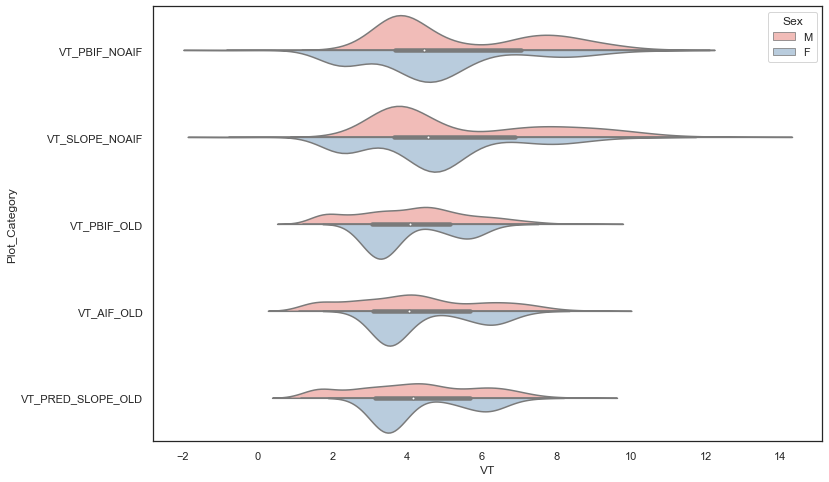

In [27]:
sns.set(style="white", rc={"figure.figsize": (12, 8)})

sns.violinplot(data=dg2, x="VT", y="Plot_Category", hue="Sex",palette="Pastel1", split=True)
plt.savefig("Violin_Sex.tif", dpi=600)

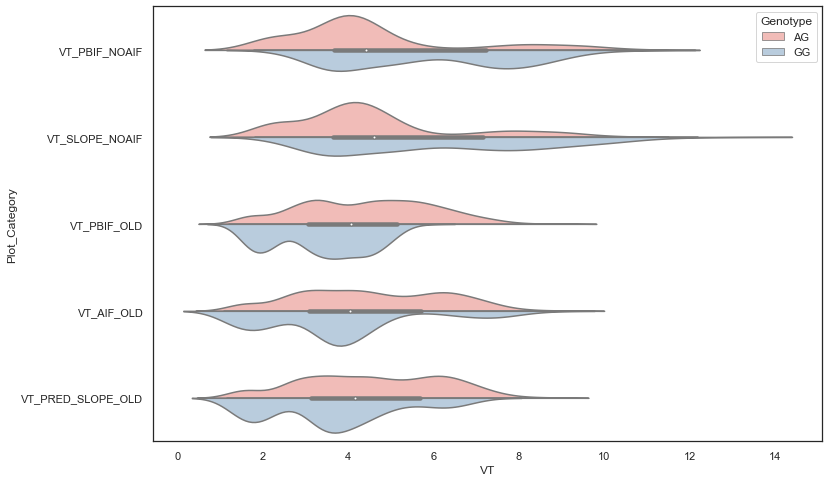

In [26]:
sns.set(style="white", rc={"figure.figsize": (12, 8)})

sns.violinplot(data=dg2.loc[dg2.Genotype!="AA"], x="VT", y="Plot_Category", hue="Genotype",palette="Pastel1", split=True)
plt.savefig("Violin_Geno.tif", dpi=600)

In [22]:
sns.violinplot?

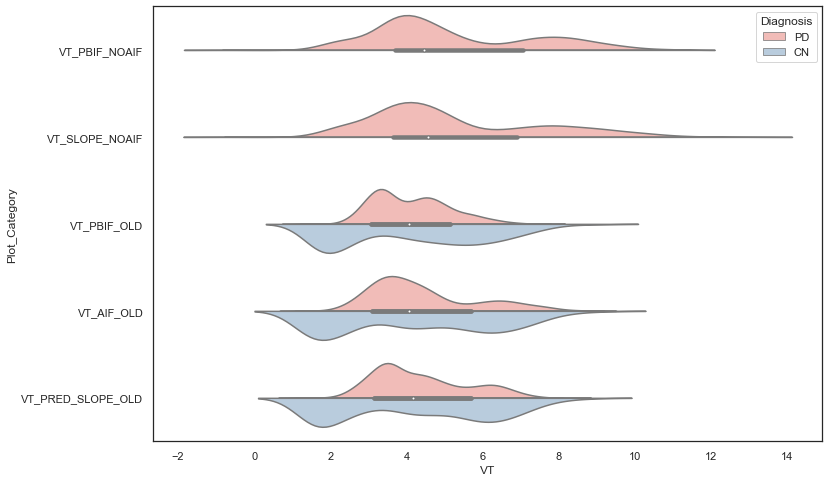

In [25]:
sns.set(style="white", rc={"figure.figsize": (12, 8)})

sns.violinplot(data=dg2, x="VT", y="Plot_Category", hue="Diagnosis",palette="Pastel1", split=True, scale="count")
plt.savefig("Violin_Diag.tif", dpi=600)

In [ ]:
#TODO: Half violins for old subjects (PD - CN).

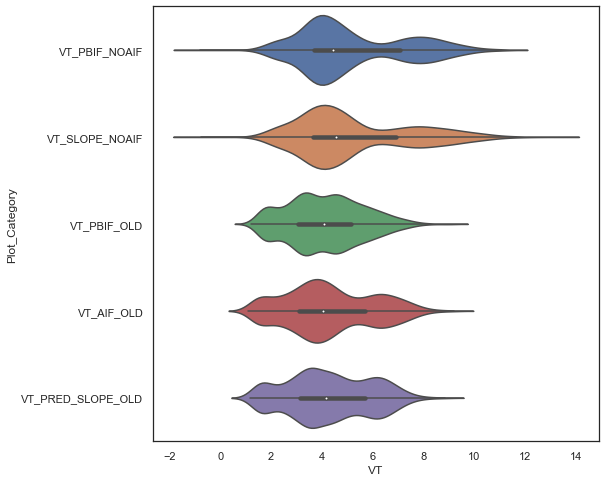

In [77]:
# dgs = pd.read_csv("../violin_results.csv")

sns.set(style="white", rc={"figure.figsize": (8, 8)})

sns.violinplot(data=dgs, x="VT", y="Plot_Category")
plt.savefig()

### LOO

In [35]:
print(X["ATLaS_ID"].unique())

['1001' '1002' '1003' '1004' '1005' '1007' '1009' '1013' '1015' '1020'
 '1022' '1023' 'FR' 'JD' 'KT' 'MM' 'PP' 'r-FR' 'r-JD' 'r-KT' 'r-MM' 'r-PP']


In [81]:
X

,ATLaS_ID,Age,Sex,NET dose (mCi),"Height (Feet, inches)",Weight (Kgs),Genotype,ctx-lh-bankssts,ctx-lh-caudalanteriorcingulate,ctx-lh-caudalmiddlefrontal,...,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC,mean,std
0,1001,68,1,16.09,5'7'',81.646627,2,3.27364,2.75754,3.09327,...,3.7842,2.79888,3.59814,3.3865,2.89171,3.35206,3.18275,3.1231,3.016650,0.300098
1,1002,59,1,14.36,5'10'',81.646627,2,4.64162,4.65717,4.77757,...,5.55904,3.95587,5.16607,5.18873,4.66438,5.05175,5.0151,5.49281,4.636139,0.424387
2,1003,63,1,12.86,6',81.646627,1,4.33058,5.06731,4.70517,...,5.16449,4.07551,4.70419,4.75161,4.71036,4.6302,4.98653,4.94004,4.516313,0.385808
3,1004,71,1,13.37,5'9'',65.770894,2,5.02903,4.37852,4.34721,...,5.56999,3.63805,5.11415,4.91874,4.07135,3.90434,3.83597,4.58288,4.524622,0.607412
4,1005,62,1,13.50,5'10'',56.245454,2,5.93189,6.31155,5.61785,...,6.84608,5.91497,6.5854,6.58945,5.65651,6.20811,6.54818,6.48155,5.645432,0.727373
5,1007,62,1,14.86,6',131.541787,2,3.92425,3.79564,3.55872,...,4.37201,2.95938,4.04435,4.75049,3.60382,3.81591,4.36867,4.53282,3.602043,0.419285
6,1009,55,0,11.15,5'3'',55.338269,1,3.13208,2.82772,2.9466,...,3.23609,2.71594,3.3007,3.29193,3.08851,3.08837,3.05847,3.24987,3.097162,0.249616
7,1013,68,1,15.49,5'10'',77.110703,1,3.84817,3.44794,3.61949,...,4.48666,3.41884,4.19103,4.65037,3.76901,4.0154,4.0634,4.08422,3.602114,0.361411
8,1015,68,1,12.65,5'7'',81.646627,2,4.53756,4.6717,4.55187,...,5.34817,3.97459,4.8538,5.59453,4.63145,4.99691,4.945,5.08579,4.579842,0.366714
9,1020,65,0,16.59,5'10'',69.853225,2,5.87316,5.9184,5.63392,...,6.68406,4.71602,5.84611,6.19483,5.62331,5.80886,5.61718,6.02118,5.527309,0.466258


In [37]:
X.loc[:, "r"] = r

Leave-One-Out model predicting ...


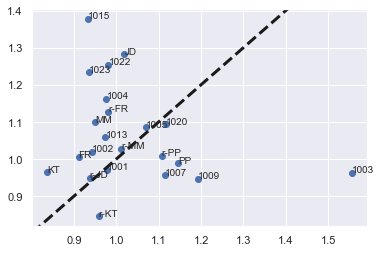

0.1627027388402847
-1.2896006194621883


In [38]:
# TODO: FIX LOO
model, error, rtrue, rpred = lou_model(
    new_df=X, paralist=selected_features, y_column="r", mode="gbr", annotations=X.ATLaS_ID)
print(np.mean(error))
print(r2_score(rtrue, rpred))

In [145]:
yhat_slope

array([0.93650103, 0.96403217, 1.46682587, 0.98410731, 1.06223147,
       1.09232733, 1.12285826, 0.98229886, 0.98220808, 1.13978222,
       1.02153763, 0.95395852, 0.93415213, 1.05807422, 0.87992058,
       0.97331024, 1.08002867])

In [31]:
# Appending the computed results using Y = r*X
subjs = df_long.ATLaS_ID.unique()

for i, subj in enumerate(subjs):
#     if i <=16:
    df_by_subj = df_long.loc[df_long.ATLaS_ID == subj]
    slope_hat = y_hat[i]
    df_by_subj.loc[:, "VT_PRED_SLOPE"] = df_by_subj["VT_PBIF"] * slope_hat
    if i == 0:
        df_plot_new_predictions = df_by_subj.copy()
    else:
        df_plot_new_predictions = pd.concat((df_plot_new_predictions, df_by_subj.copy()), axis=0)

In [40]:
df_plot_new_predictions = pd.read_csv("ml_results_long.csv")

In [41]:
x = df_plot_new_predictions['VT_PRED_SLOPE'].values.astype(float)
y = df_plot_new_predictions['VT_AIF'].values.astype(float)
a, b = np.polyfit(x, y, 1)

r2_score(y, x)

0.9706501013481474

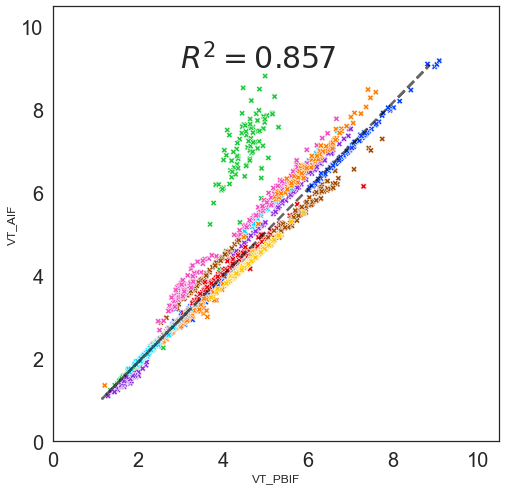

In [42]:
sns.set(style="white", rc={"figure.figsize": (8, 8)})
sns.scatterplot(data=df_plot_new_predictions, x='VT_PBIF',
                y='VT_AIF', hue="ATLaS_ID", palette="bright", marker="X", legend=None)

plt.annotate(r"$R^2 = 0.857$",(3,9), fontsize=30)
# plt.title("Re-Scaled Results", fontsize=20)
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2.5, alpha=0.6)
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig("PBIF_20230821.png", dpi=600)

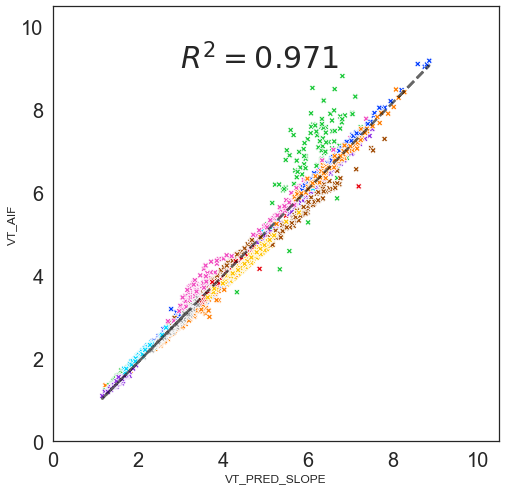

In [50]:
sns.set(style="white", rc={"figure.figsize": (8, 8)})
sns.scatterplot(data=df_plot_new_predictions, x='VT_PRED_SLOPE',
                y='VT_AIF', hue="ATLaS_ID", palette="bright", marker="X", legend=None)

# plt.xlabel(None)
plt.annotate(r"$R^2 = 0.971$",(3,9), fontsize=30)
# plt.title("Re-Scaled Results", fontsize=20)
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2.5, alpha=0.6)
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig("SLOPE_20230821.png", dpi=600)

In [39]:
df_plot_new_predictions.to_csv("ml_results_long.csv")

### Calculation

In [20]:
df_plot_long.head()

NameError: name 'df_plot_long' is not defined

In [17]:
# Appending the computed results using Y = r*X
subjs = df_plot_long.ATLaS_ID.unique()

for i, subj in enumerate(subjs):
    df_by_subj = df_plot_long.loc[df_plot_long.ATLaS_ID == subj]
    slope_hat = yhat_slope[i]
    df_by_subj.loc[:, "VT_PRED_SLOPE"] = df_by_subj["VT_PBIF_NEW"] * slope_hat
    if i == 0:
        df_plot_new_predictions = df_by_subj.copy()
    else:
        df_plot_new_predictions = pd.concat((df_plot_new_predictions, df_by_subj.copy()), axis=0)

In [18]:
df_plot_new_predictions.head()

,ATLaS_ID,regions_PBIF,VT_PBIF,regions_AIF,VT_AIF,VT_PBIF_NEW,VT_PRED_SLOPE
0,1001,ctx-lh-bankssts-PBIF,3.535561,ctx-lh-bankssts-AIF,3.125203,3.535561,3.230355
17,1001,ctx-lh-bankssts-PBIF,3.168570,ctx-lh-bankssts-AIF,2.927193,3.168570,2.895044
34,1001,ctx-lh-caudalanteriorcingulate-PBIF,1.338301,ctx-lh-caudalanteriorcingulate-AIF,1.873116,1.338301,1.222772
51,1001,ctx-lh-caudalanteriorcingulate-PBIF,2.618238,ctx-lh-caudalanteriorcingulate-AIF,2.312698,2.618238,2.392219
68,1001,ctx-lh-caudalmiddlefrontal-PBIF,3.597507,ctx-lh-caudalmiddlefrontal-AIF,3.026488,3.597507,3.286954


### Ploting

In [22]:
df_long

,ATLaS_ID,variable,VT_PBIF,VT_AIF,VT_Rebalanced
0,1001,ctx-lh-bankssts,3.27364,3.25101,0.647637
1,1002,ctx-lh-bankssts,4.64162,4.35411,0.167196
2,1003,ctx-lh-bankssts,4.33058,6.68856,-0.0245965
3,1004,ctx-lh-bankssts,5.02903,4.90244,0.168688
4,1005,ctx-lh-bankssts,5.93189,6.32852,0.0936723
...,...,...,...,...,...
1887,r-FR,Right-VentralDC,3.34727,3.28905,1.04405
1888,r-JD,Right-VentralDC,5.30888,4.97198,0.412965
1889,r-KT,Right-VentralDC,2.7265,2.56848,-0.463781
1890,r-MM,Right-VentralDC,9.08693,9.18805,-0.450177


In [20]:
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

('Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 'afmhot',
 'afmhot_r',
 'autumn',
 'autumn_r',
 'binary',
 'binary_r',
 'bone',
 'bone_r',
 'brg',
 'brg_r',
 'bwr',
 'bwr_r',
 'cividis',
 'cividis_r',
 'cool',
 'cool_r',
 'co

In [21]:
df_plot_new_predictions.columns

Index(['ATLaS_ID', 'regions_PBIF', 'VT_PBIF', 'regions_AIF', 'VT_AIF',
       'VT_PBIF_NEW', 'VT_PRED_SLOPE'],
      dtype='object')

0.9525071501756254


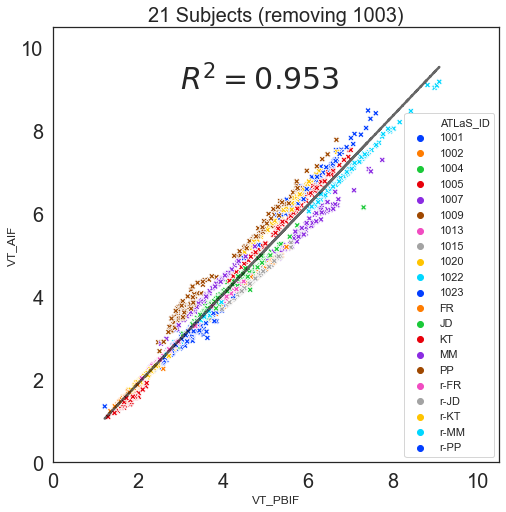

In [196]:
sns.set(style="white", rc={"figure.figsize": (8, 8)})

df_long_new = df_long.loc[df_long.ATLaS_ID!="1003"].copy()
x = df_long_new['VT_PBIF'].astype(float).values
y = df_long_new['VT_AIF'].astype(float).values
a, b = np.polyfit(x, y, 1)
print(r2_score(y, x))
sns.scatterplot(data=df_long_new, x='VT_PBIF',
                y='VT_AIF', hue="ATLaS_ID", palette="bright", marker="X")

plt.xlabel = None
plt.ylabel = None
plt.title("21 Subjects (removing 1003)", fontsize=20)
plt.annotate(r"$R^2 = 0.953$",(3,9), fontsize=30)
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2.5, alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

0.8573570077617896


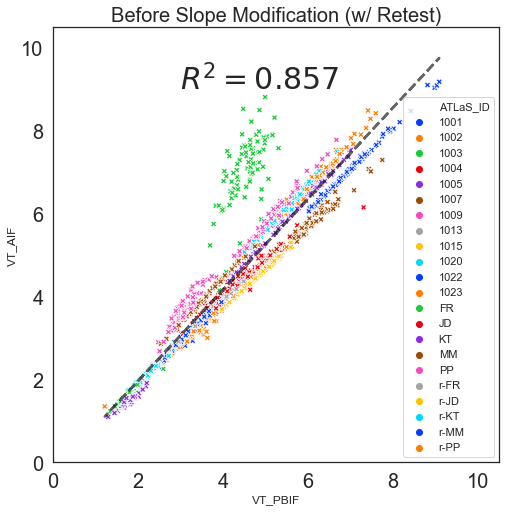

In [21]:
sns.set(style="white", rc={"figure.figsize": (8, 8)})


x = df_long['VT_PBIF'].astype(float).values
y = df_long['VT_AIF'].astype(float).values
a, b = np.polyfit(x, y, 1)
print(r2_score(y, x))
sns.scatterplot(data=df_long, x='VT_PBIF',
                y='VT_AIF', hue="ATLaS_ID", palette="bright", marker="X")

plt.xlabel = None
plt.ylabel = None
plt.title("Before Slope Modification (w/ Retest)", fontsize=20)
plt.annotate(r"$R^2 = 0.857$",(3,9), fontsize=30)
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2.5, alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [170]:
df_long.VT_Rebalanced.astype(float).describe()

count    1892.000000
mean       -0.049856
std         1.264847
min       -35.425998
25%        -0.077796
50%         0.044762
75%         0.149005
max        11.579727
Name: VT_Rebalanced, dtype: float64

-6.863807002043325


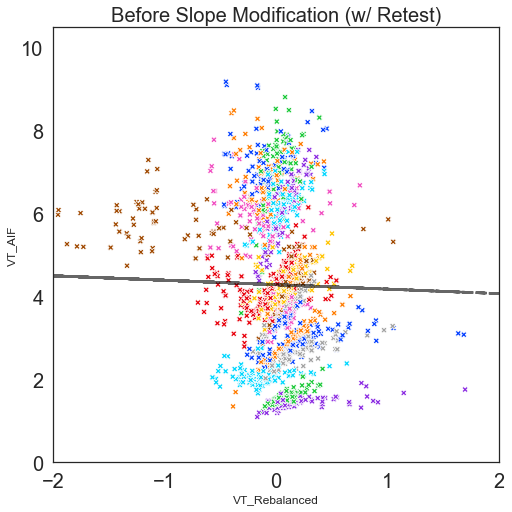

In [173]:
sns.set(style="white", rc={"figure.figsize": (8, 8)})

x = df_long['VT_Rebalanced'].astype(float).values
y = df_long['VT_AIF'].astype(float).values
a, b = np.polyfit(x, y, 1)
print(r2_score(y, x))
sns.scatterplot(data=df_long, x='VT_Rebalanced',
                y='VT_AIF', hue="ATLaS_ID", palette="bright", marker="X", legend=None)

plt.xlabel = None
plt.ylabel = None
plt.title("Before Slope Modification (w/ Retest)", fontsize=20)
plt.annotate(r"$R^2 = -6.86$",(3,9), fontsize=30)
plt.xlim(-2, 2)
plt.ylim(0, 10.5)
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2.5, alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

-8.833614001469847


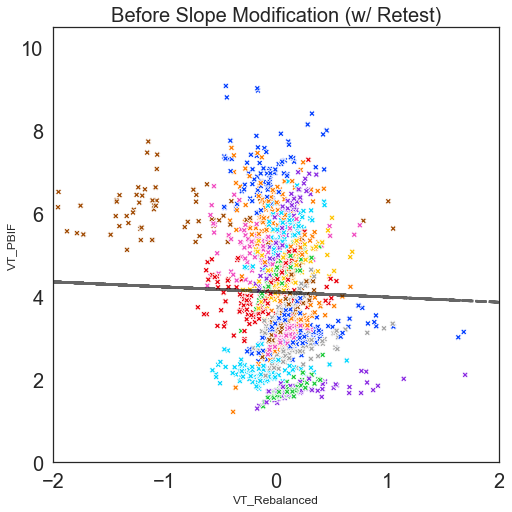

In [175]:
sns.set(style="white", rc={"figure.figsize": (8, 8)})

x = df_long['VT_Rebalanced'].astype(float).values
y = df_long['VT_PBIF'].astype(float).values
a, b = np.polyfit(x, y, 1)
print(r2_score(y, x))
sns.scatterplot(data=df_long, x='VT_Rebalanced',
                y='VT_PBIF', hue="ATLaS_ID", palette="bright", marker="X", legend=None)

plt.xlabel = None
plt.ylabel = None
plt.title("Before Slope Modification (w/ Retest)", fontsize=20)
plt.annotate(r"$R^2 = -8.83$",(3,9), fontsize=30)
plt.xlim(-2, 2)
plt.ylim(0, 10.5)
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2.5, alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [98]:
df_long

,ATLaS_ID,variable,VT_PBIF,VT_AIF
0,1001,ctx-lh-bankssts,3.27364,3.25101
1,1002,ctx-lh-bankssts,4.64162,4.35411
2,1003,ctx-lh-bankssts,4.33058,6.68856
3,1004,ctx-lh-bankssts,5.02903,4.90244
4,1005,ctx-lh-bankssts,5.93189,6.32852
...,...,...,...,...
1887,r-FR,Right-VentralDC,3.34727,3.28905
1888,r-JD,Right-VentralDC,5.30888,4.97198
1889,r-KT,Right-VentralDC,2.7265,2.56848
1890,r-MM,Right-VentralDC,9.08693,9.18805


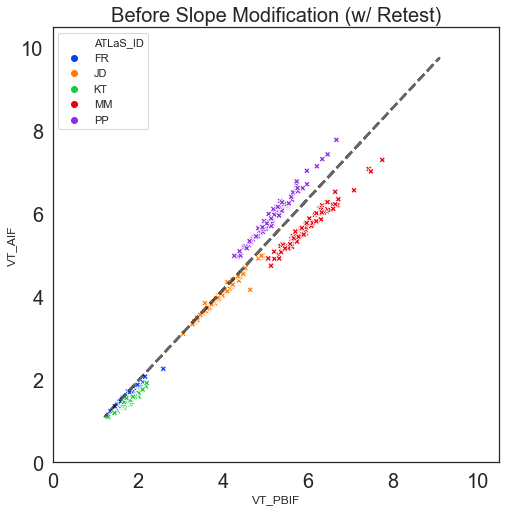

In [108]:
# dft = df_long.loc[df_long.ATLaS_ID.isin(['r-FR','r-JD', 'r-KT', 'r-MM', 'r-PP'])]
dft = df_long.loc[df_long.ATLaS_ID.isin(['FR','JD', 'KT', 'MM', 'PP'])]
sns.set(style="white", rc={"figure.figsize": (8, 8)})
sns.scatterplot(data=dft, x='VT_PBIF',
                y='VT_AIF', hue="ATLaS_ID", palette="bright", marker="X")

plt.xlabel = None
plt.ylabel = None
plt.title("Before Slope Modification (w/ Retest)", fontsize=20)
# plt.annotate(r"$R^2 = 0.857$",(3,9), fontsize=30)
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2.5, alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

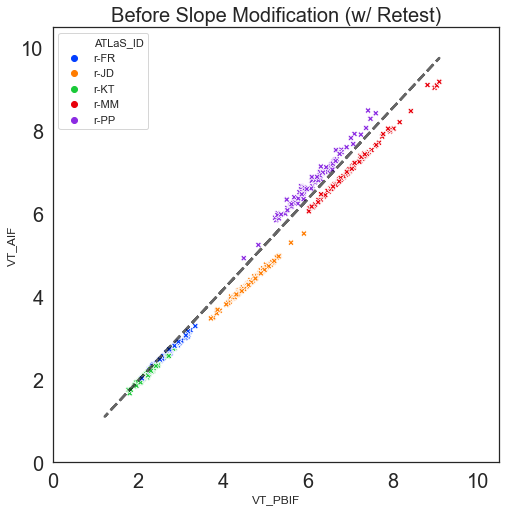

In [102]:
dft = df_long.loc[df_long.ATLaS_ID.isin(['r-FR','r-JD', 'r-KT', 'r-MM', 'r-PP'])]
# dft = df_long.loc[df_long.ATLaS_ID.isin(['FR','JD', 'KT', 'MM', 'PP'])]
sns.set(style="white", rc={"figure.figsize": (8, 8)})
sns.scatterplot(data=dft, x='VT_PBIF',
                y='VT_AIF', hue="ATLaS_ID", palette="bright", marker="X")

plt.xlabel = None
plt.ylabel = None
plt.title("Before Slope Modification (w/ Retest)", fontsize=20)
# plt.annotate(r"$R^2 = 0.857$",(3,9), fontsize=30)
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2.5, alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

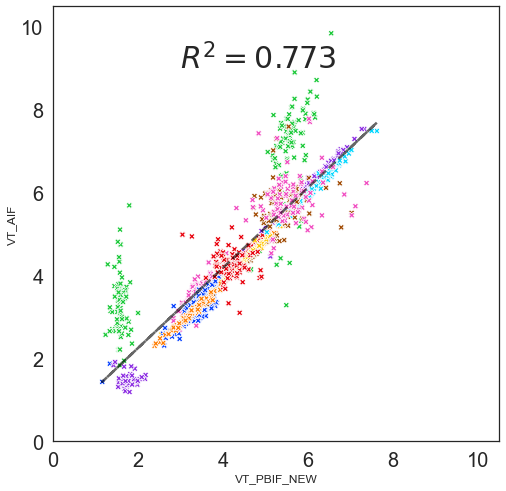

In [31]:
sns.set(style="white", rc={"figure.figsize": (8, 8)})
sns.scatterplot(data=df_plot_new_predictions, x='VT_PBIF_NEW',
                y='VT_AIF', hue="ATLaS_ID", palette="bright", marker="X", legend=None)

plt.xlabel = None
plt.ylabel = None
plt.annotate(r"$R^2 = 0.773$",(3,9), fontsize=30)
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2.5, alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.show()
# plt.savefig("PSAIF_20230402.png", dpi=600)

In [32]:
x = df_plot_new_predictions['VT_PRED_SLOPE'].values
y = df_plot_new_predictions['VT_AIF'].values
a, b = np.polyfit(x, y, 1)

In [33]:
r2_score(y, x)

0.9215098431194113

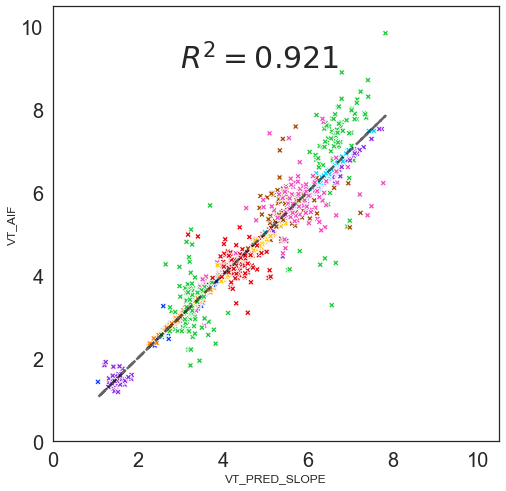

In [35]:
sns.set(style="white", rc={"figure.figsize": (8, 8)})
sns.scatterplot(data=df_plot_new_predictions, x='VT_PRED_SLOPE',
                y='VT_AIF', hue="ATLaS_ID", palette="bright", marker="X", legend=None)

# plt.xlabel(None)
# plt.ylabel(None)
plt.annotate(r"$R^2 = 0.921$",(3,9), fontsize=30)
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2.5, alpha=0.6)
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
plt.tick_params(axis='both', which='major', labelsize=20)

# plt.savefig("SLOPE_20230402.png", dpi=600)

In [37]:
df_plot_new_predictions.columns

Index(['ATLaS_ID', 'regions_PBIF', 'VT_PBIF', 'regions_AIF', 'VT_AIF',
       'VT_PBIF_NEW', 'VT_PRED_SLOPE'],
      dtype='object')

In [50]:
df.loc[df.ATLaS_ID.str.startswith("1"), "PD"] = 1
df.loc[~df.ATLaS_ID.str.startswith("1"), "PD"] = 0

In [52]:
merged_df = pd.merge(df, df_plot_new_predictions, on='ATLaS_ID')

In [54]:
merged_df.columns

Index(['ATLaS_ID', 'Age', 'Sex', 'Dose', 'Height', 'Weight', 'Genotype', 'auc',
       'PD', 'regions_PBIF', 'VT_PBIF', 'regions_AIF', 'VT_AIF', 'VT_PBIF_NEW',
       'VT_PRED_SLOPE'],
      dtype='object')

In [64]:
merged_df.Sex.unique()

array([1., 0.])

In [61]:
import matplotlib.patches as mpatches

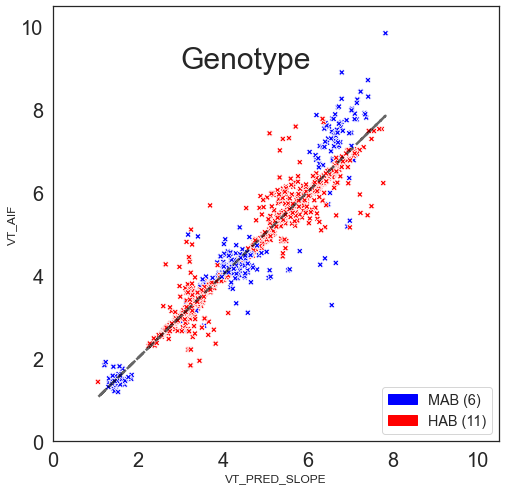

In [80]:
sns.set(style="white", rc={"figure.figsize": (8, 8)})

# Define a custom palette with exactly two colors
custom_palette = {1: 'blue', 2: 'red'}
sns.scatterplot(data=merged_df, x='VT_PRED_SLOPE',
                y='VT_AIF', hue="Genotype", palette=custom_palette, marker="X", legend=None)

# plt.annotate(f"Genotype MAB-Blue; HAB-RED",(1,9), fontsize=20)
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2.5, alpha=0.6)
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
plt.annotate(f"Genotype",(3,9), fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
# Create custom legend labels
MAB_patch = mpatches.Patch(color='blue', label='MAB (6)')
HAB_patch = mpatches.Patch(color='red', label='HAB (11)')

# Add the custom legend to the plot
plt.legend(handles=[MAB_patch, HAB_patch], fontsize='large', loc='lower right')
plt.savefig("Genotype.png", dpi=600)


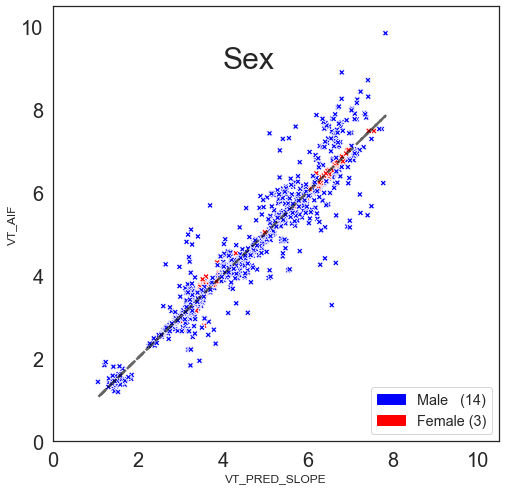

In [81]:
sns.set(style="white", rc={"figure.figsize": (8, 8)})

# Define a custom palette with exactly two colors
custom_palette = {1: 'blue', 0: 'red'}
sns.scatterplot(data=merged_df, x='VT_PRED_SLOPE',
                y='VT_AIF', hue="Sex", palette=custom_palette, marker="X", legend=None)

# plt.annotate(f"Genotype MAB-Blue; HAB-RED",(1,9), fontsize=20)
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2.5, alpha=0.6)
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)

plt.annotate(f"Sex",(4,9), fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
# Create custom legend labels
MAB_patch = mpatches.Patch(color='blue', label='Male   (14)')
HAB_patch = mpatches.Patch(color='red', label='Female (3)')

# Add the custom legend to the plot
plt.legend(handles=[MAB_patch, HAB_patch], fontsize='large', loc='lower right')
plt.savefig("Sex.png", dpi=600)


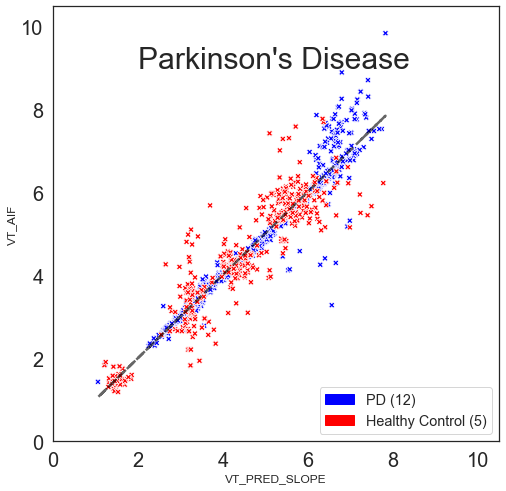

In [82]:
sns.set(style="white", rc={"figure.figsize": (8, 8)})

# Define a custom palette with exactly two colors
custom_palette = {1: 'blue', 0: 'red'}
sns.scatterplot(data=merged_df, x='VT_PRED_SLOPE',
                y='VT_AIF', hue="PD", palette=custom_palette, marker="X", legend=None)

# plt.annotate(f"Genotype MAB-Blue; HAB-RED",(1,9), fontsize=20)
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2.5, alpha=0.6)
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)

plt.annotate(f"Parkinson's Disease",(2,9), fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
# Create custom legend labels
MAB_patch = mpatches.Patch(color='blue', label='PD (12)')
HAB_patch = mpatches.Patch(color='red', label='Healthy Control (5)')

# Add the custom legend to the plot
plt.legend(handles=[MAB_patch, HAB_patch], fontsize='large', loc='lower right')
plt.savefig("PD_HC.png", dpi=600)


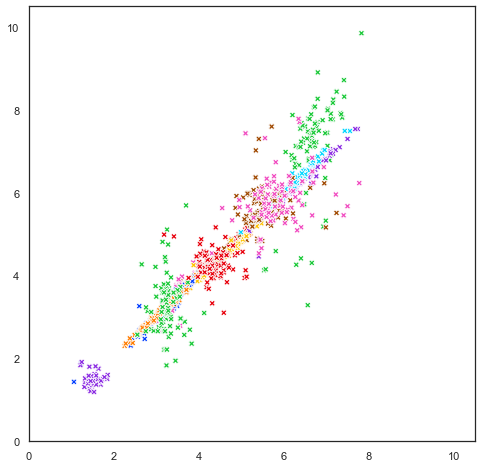

In [35]:
sns.set(style="white", rc={"figure.figsize": (8, 8)})
sns.scatterplot(data=df_plot_new_predictions, x='VT_PRED_SLOPE',
                y='VT_AIF', hue="ATLaS_ID", palette="bright", marker="X", legend=None)
# plt.title('Observed Logan VT from PBIF and AIF - Slope Rescaling Model')
# plt.xlabel('Observed Logan VT from PBIF w/ Slope Rescaling')
plt.xlabel(None)
plt.ylabel(None)
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
# plt.ylabel('Observed Logan VT from AIF')

# Add square border
# plt.gca().spines['left'].set_linewidth(1)
# plt.gca().spines['bottom'].set_linewidth(1)
# plt.gca().spines['right'].set_linewidth(1)
# plt.gca().spines['top'].set_visible(True)

# sns.despine()
plt.show()

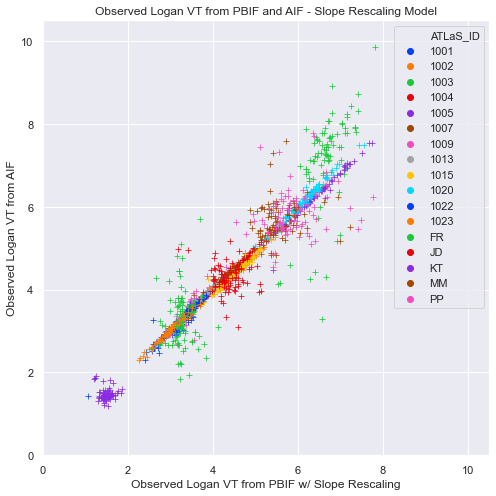

In [21]:
# The Y = r*X + 0
# sns.palettes("husl", 16)
sns.color_palette("hls", 16)
sns.set(rc={"figure.figsize": (8, 8)})
sns.scatterplot(data=df_plot_new_predictions, x='VT_PRED_SLOPE',
                y='VT_AIF', hue="ATLaS_ID", palette="bright", marker="+")
sns.color_palette("hls", 16)
plt.title('Observed Logan VT from PBIF and AIF - Slope Rescaling Model')
plt.xlabel('Observed Logan VT from PBIF w/ Slope Rescaling')
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
plt.ylabel('Observed Logan VT from AIF')
plt.show()
# plt.savefig("SlopeModel_20230301.png", dpi=600)

In [24]:
mean_absolute_error(df_plot_new_predictions.VT_AIF, df_plot_new_predictions.VT_PRED_SLOPE)

0.21984968881194686

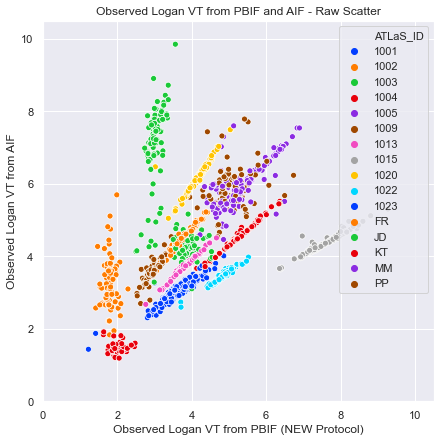

In [110]:
sns.set(rc={"figure.figsize":(7, 7)})

# plot original data --- NEW
sns.scatterplot(data=df_plot_long, x='VT_PBIF_NEW', y='VT_AIF', hue="ATLaS_ID", palette="bright")
plt.title('Observed Logan VT from PBIF and AIF - Raw Scatter')
plt.xlabel('Observed Logan VT from PBIF (NEW Protocol)')
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
plt.ylabel('Observed Logan VT from AIF')
# plt.show()
plt.savefig("Original_scatter_plot_20131011.png", dpi=600)

In [148]:
ulk = {}
IDs = df_plot_new_predictions.ATLaS_ID.unique()
for sid in IDs:
    tmp_df = df_plot_new_predictions.loc[df_plot_new_predictions.ATLaS_ID==sid]
    ulk[sid] = r2_score(tmp_df.VT_AIF, tmp_df.VT_PRED_SLOPE)
    

In [150]:
df_plot_new_predictions

,ATLaS_ID,regions_PBIF,VT_PBIF,regions_AIF,VT_AIF,VT_PBIF_NEW,VT_PRED_SLOPE
0,1001,ctx-lh-bankssts-PBIF,3.618592,ctx-lh-bankssts-AIF,3.125203,3.632488,3.094713
16,1001,ctx-lh-bankssts-PBIF,3.251344,ctx-lh-bankssts-AIF,2.927193,3.354556,2.857927
32,1001,ctx-lh-caudalanteriorcingulate-PBIF,1.764931,ctx-lh-caudalanteriorcingulate-AIF,1.873116,1.415929,1.206306
48,1001,ctx-lh-caudalanteriorcingulate-PBIF,2.663417,ctx-lh-caudalanteriorcingulate-AIF,2.312698,2.799238,2.384822
64,1001,ctx-lh-caudalmiddlefrontal-PBIF,3.675814,ctx-lh-caudalmiddlefrontal-AIF,3.026488,3.816396,3.251394
...,...,...,...,...,...,...,...
1311,PP,Left-Amygdala-PBIF,3.830682,Left-Amygdala-AIF,6.278149,5.581217,6.408240
1327,PP,Left-Accumbens-area-PBIF,4.258944,Left-Accumbens-area-AIF,6.845310,5.776103,6.632005
1343,PP,Left-Accumbens-area-PBIF,3.937894,Left-Accumbens-area-AIF,6.252835,5.340895,6.132308
1359,PP,Left-VentralDC-PBIF,4.091883,Left-VentralDC-AIF,6.621300,6.017672,6.909370


In [156]:
ulk

{'1001': 0.8178107985143418,
 '1002': 0.9485094611423879,
 '1003': -0.48971944726208516,
 '1004': 0.6996961544128686,
 '1005': 0.9646984483921023,
 '1009': 0.5081679776720256,
 '1013': 0.9115115207298585,
 '1015': -0.15632175369387258,
 '1020': 0.7606979696731138,
 '1022': -3.3267229236984495,
 '1023': 0.6913727963915005,
 'FR': -0.17118618332936308,
 'JD': -1.1885748001536451,
 'KT': -7.959913526933791,
 'MM': -1.338870648152286,
 'PP': -0.5323650378516933}

In [24]:
# # Report R value or individual LinR (slope==1, intercept==0)
# # The Y = r*X + 0
# for outlier in ['1003', '1015', '1022', 'FR', 'JD', "KT", 'MM', 'PP']:
#     sns.color_palette("hls", 16)
#     sns.set(rc={"figure.figsize": (7, 7)})
#     sns.scatterplot(data=df_plot_new_predictions.loc[df_plot_new_predictions.ATLaS_ID == outlier], x='VT_PRED_SLOPE',
#                     y='VT_AIF')
#     sns.color_palette("hls", 16)
#     plt.title('Observed Logan VT from PBIF and AIF - Slope Rescaling Model')
#     plt.xlabel('Observed Logan VT from PBIF w/ Slope Rescaling')
#     # plt.xlim(0, 10.5)
#     # plt.ylim(0, 10.5)
#     plt.ylabel('Observed Logan VT from AIF')
#     plt.show()
#     # plt.savefig("SlopeModel_20230111_husl.png", dpi=600)

In [25]:
# r2_score(df_plot_new_predictions.VT_AIF, df_plot_new_predictions.VT_PRED_SLOPE)

In [ ]:
# 